Here's a template of the kind of exploration, preprocessing, model construction and evaluation I want to do with each project

<h1> Outline </h1>
<h2>Data exploration</h2>

* Distributions (broken down by class)
    * Intensity distributions per sample (boxplots)
        * Make sure no samples are weird
    * Mean Feature Intensity (broken down by class) 
        * Make sure classes don't look obviously wonky (batch effect)
    * Feature Sparsity distributions per sample (distplot)
        * Look for batch effect
    * Mean Feature Sparsity distribution (distplot)
        * Batch effects?

* Covariates
    * intensity x variance
    * rt x intensity
    * mz x intensity
    * rt-width x intensity
    * mzwid x intensity


* Statistics
    * MW-pvals distributions, stratified by
        * Variance
        * mean feature Intensity
        * mean feature Sparsity
        * rt
        * mz

* Unsupervised viz (visualize by class)
    * PCA
    * Clustering
    * cosine similarity matrices?

<h2> Data Preprocessing </h2>
* Filtering
    * Variance filter
* Transformation
    * Dilution correction (PQN-normalization)
    * Misisng value imputation (fill zero's with 1/2 the minimum intensity detected)
    * log transformation and no-log-transform (branchpoint for downstream analyses)
    * Robust scaler (subtract median, scale by IQR)

<h2> Add in pos/neg mode features (branchpoint)</h2>
* Process separately, and also together
* After preprocessing steps have been looked at/through and filtering performed, combine the positive and negative mode data

<h2> Feature Selection </h2>
* Dimensionality reduction (branchpoint)
    * PCA
    * Hierarchical clustering
    * Problem: These features won't generalize, so not extensible beyond current study
    

<h2> Classification </h2>
* RF
* Logistic regression
    * with l-1 penalty for sparsity



<h3> Load the data </h3>

In [73]:
import subprocess
subprocess.call('pip install mwtab', shell=True)
%load_ext autoreload
import src.project_fxns.organize_xcms as xcms_fxns
import src.data.preprocessing as preproc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import src.data.data_exploration as explore
import pandas as pd
import scipy.stats as stats

# scikit
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mtbls315_pos = xcms_fxns.Xcms_organize(
        '/home/data/processed/MTBLS315/uhplc_pos/xcms_result.tsv'
)
mtbls315_pos.remove_column_prefix(prefix='X')

# get class to samplename mapping
class_col = 'Factor Value[patient group]'
mtbls315_pos.mtbls_class_mapping(
'/home/data/raw/MTBLS315/a_UPLC_POS_nmfi_and_bsi_diagnosis.txt',
'/home/data/raw/MTBLS315/s_NMFI and BSI diagnosis.txt', 
class_col)

# encode classes as numeric
mtbls315_pos.class_encoder()

Were you expecting 3 classes? because thats how many you have. look at self.sample_classes if this is unexpected


In [3]:
# Samples are from 3 classes, I might want to just differentiate between two
mtbls315_pos.class_dict
no_mal = np.concatenate([mtbls315_pos.class_dict['bacterial bloodstream infection'],
                mtbls315_pos.class_dict['non-malarial febrile illness']])
mal = mtbls315_pos.class_dict['malaria']
new_class_dict = {'malaria': mal, 'non-malarial fever': no_mal}

### Data Exploration

In [4]:
(mtbls315_pos.feature_table < 1e-15).sum().sum()

121007

In [5]:
zeros / float(num_feats)

NameError: name 'zeros' is not defined

In [247]:
num_feats = mtbls315_pos.feature_table.shape[1] * mtbls315_pos.feature_table.shape[0]
zeros = (mtbls315_pos.feature_table < 1e-15).sum().sum()
print('Original number of zeros %s, %.2f%% ' % (zeros, 100*float(zeros)/num_feats)
     )
print('Original number of NaNs %s' % mtbls315_pos.feature_table.isnull().sum().sum()
     )
zero_filled = explore.fill_zero_nan(mtbls315_pos.feature_table)
print('Zero-filled number of zeros %s' % (zero_filled < 1e-15).sum().sum()
     )
print('Zero-filled number of NaNs %s' % zero_filled.isnull().sum().sum()
     )
print('Zero-filled min: %s' % zero_filled.min().min())

Original number of zeros 121007, 8.98% 
Original number of NaNs 0
Zero-filled number of zeros 0
Zero-filled number of NaNs 0
Zero-filled min: 217.13836028


In [14]:
# Sample Intensity distributions
tidy = explore.tidy(zero_filled)
tidy['value'] = np.log10(tidy['value'])
tidy

,index,variable,value
0,1001_P,100.075432918:130.5724,4.615378
1,1002_P,100.075432918:130.5724,5.206816
2,1003_P,100.075432918:130.5724,5.004543
3,1004_P,100.075432918:130.5724,5.273708
4,1005_P,100.075432918:130.5724,4.440325
5,1006_P,100.075432918:130.5724,6.784475
6,1007_P,100.075432918:130.5724,4.903290
7,1009_P,100.075432918:130.5724,6.025914
8,1010_P,100.075432918:130.5724,4.999858
9,1011_P,100.075432918:130.5724,4.916920


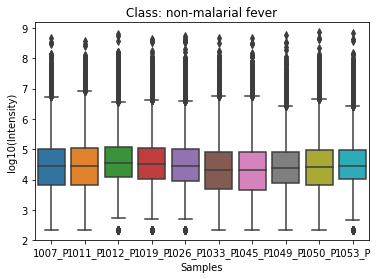

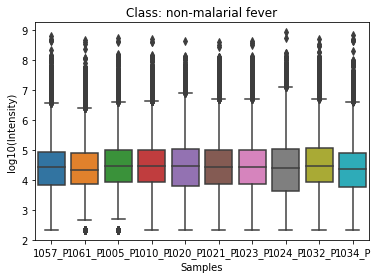

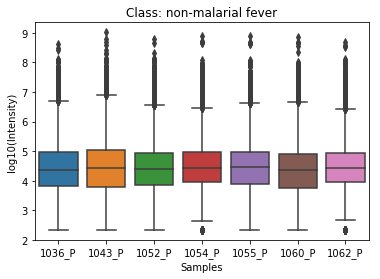

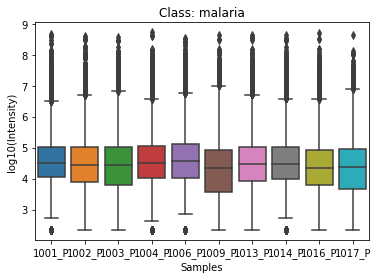

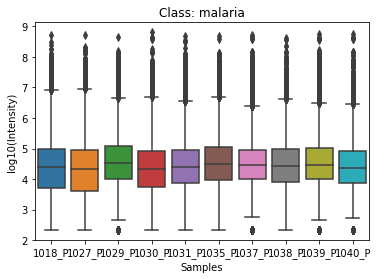

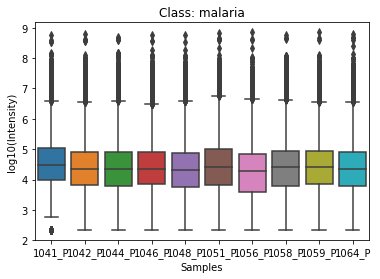

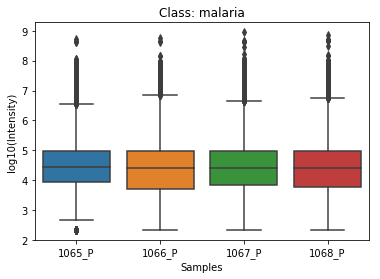

In [55]:
axes = explore.sample_feature_intensity(tidy, 
                                new_class_dict, ylabel='log10(Intensity)',
                                       xlabel='Samples')

non-malarial fever
malaria


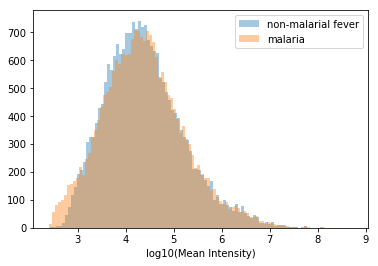

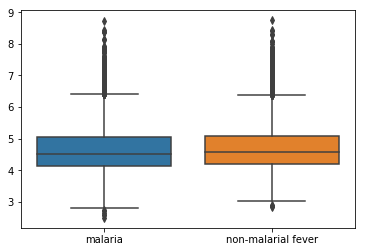

In [70]:
# Mean intensity per feature
axes = explore.distplot_classes(np.log10(zero_filled),
    class_dict=new_class_dict, fxn=np.mean,
    axlabel='log10(Mean Intensity)', bins=100,
                               kde=False)
plt.show()

# Mean intensity per feature per class
df_mean = pd.DataFrame({k: np.mean(zero_filled.loc[v], axis=0)
                       for k, v in new_class_dict.iteritems()}
                      )
sns.boxplot(data=np.log10(df_mean))

non-malarial fever
malaria


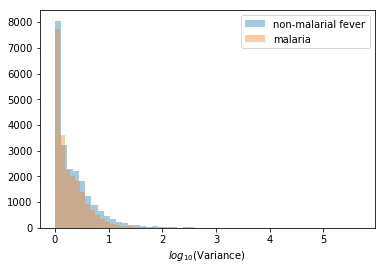

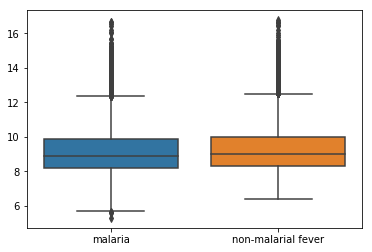

In [71]:
explore.distplot_classes(
    np.log10(zero_filled), class_dict=new_class_dict,
    fxn=np.var, axlabel='$log_{10}$(Variance)', bins=50, kde=False)

plt.show()

df_var = pd.DataFrame({k: np.var(zero_filled.loc[v], axis=0)
                 for k, v in new_class_dict.iteritems()}
            )
sns.boxplot(data=np.log10(df_var))
plt.show()

non-malarial fever
malaria


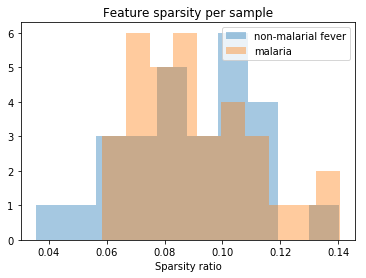

In [10]:
# Sparsity per sample
sample_sparsity = ((mtbls315_pos.feature_table < 1e-15).sum(axis=1) 
                   / mtbls315_pos.feature_table.shape[1])
ax = explore.distplot_classes(sample_sparsity, new_class_dict,
                             kde=False, bins=10)
for graph in ax:
    graph.set_title('Feature sparsity per sample')
    graph.set_xlabel('Sparsity ratio')

['1007_P' '1011_P' '1012_P' '1019_P' '1026_P' '1033_P' '1045_P' '1049_P'
 '1050_P' '1053_P' '1057_P' '1061_P' '1005_P' '1010_P' '1020_P' '1021_P'
 '1023_P' '1024_P' '1032_P' '1034_P' '1036_P' '1043_P' '1052_P' '1054_P'
 '1055_P' '1060_P' '1062_P']


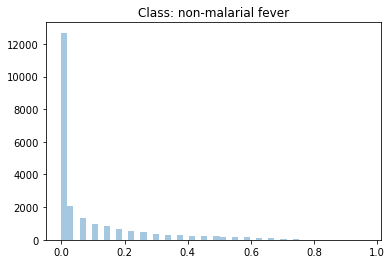

['1001_P' '1002_P' '1003_P' '1004_P' '1006_P' '1009_P' '1013_P' '1014_P'
 '1016_P' '1017_P' '1018_P' '1027_P' '1029_P' '1030_P' '1031_P' '1035_P'
 '1037_P' '1038_P' '1039_P' '1040_P' '1041_P' '1042_P' '1044_P' '1046_P'
 '1048_P' '1051_P' '1056_P' '1058_P' '1059_P' '1064_P' '1065_P' '1066_P'
 '1067_P' '1068_P']


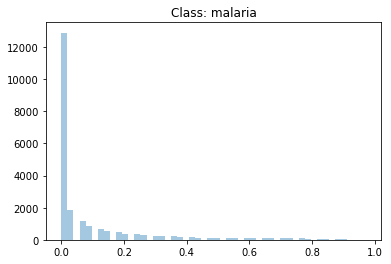

In [39]:
# Distribution of mean feature sparsity
for k, v in new_class_dict.iteritems():
    print(v)
    feature_sparsity = ((mtbls315_pos.feature_table.loc[v] < 1e-15).sum(axis=0)
                        / mtbls315_pos.feature_table.loc[v].shape[0])
    ax = explore.distplot_classes(feature_sparsity,
                        kde=False)
    ax.set_title('Class: %s' % k)
    plt.show()

#### Stats

In [122]:
mw_output = explore.two_group_stat(zero_filled, new_class_dict,
                       stats.mannwhitneyu, alternative='two-sided')

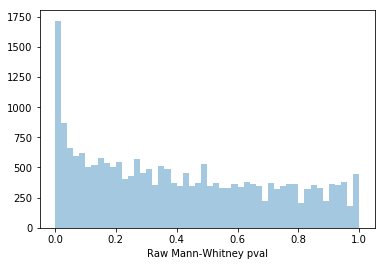

In [123]:
# pval distribution (*2 because it should be two-tailed)
mw_pvals = np.array([i[1] for i in mw_output])
sns.distplot(mw_pvals, bins=50, kde=False,
            axlabel='Raw Mann-Whitney pval')

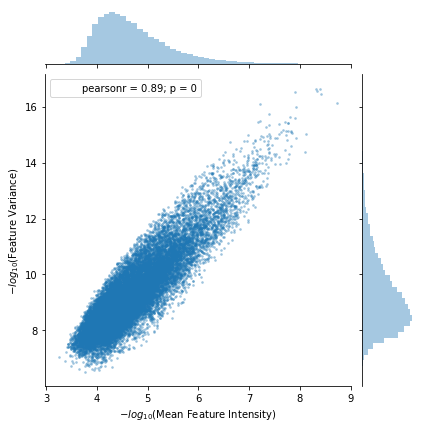

In [260]:
g = sns.jointplot(np.log10(np.mean(zero_filled, axis=0)),
             np.log10(np.var(zero_filled, axis=0)),
             s=3, alpha=0.3)
g.set_axis_labels('$-log_{10}$(Mean Feature Intensity)', 
                  '$-log_{10}$(Feature Variance)')


## Stratify by covariates

In [241]:
# Stratify by covariates
covariates = mtbls315_pos.all_data.T.loc[['mz', 'rt',
                            'mzmin', 'mzmax', 'rtmin', 'rtmax']].T
# Get just the pvalue as a series
mw_pval_series = mw_output.apply(lambda x: x[1])

In [264]:
def pval_strat_hist_and_scatter(covar, stats, covar_name='Covariate',
    **kwargs):
    # First plot stratified pval histograms
    axes = explore.plot_pvals_stratified(covar, stats, covar_name,
                                        **kwargs)
    plt.show()
    # Next plot scatter plot with real values
    df = pd.concat([covar, stats], axis=1, keys=[covar_name, 'pval'])
    g = sns.jointplot(df[covar_name], -np.log10(df['pval']),
                     s=10, alpha=0.3)
    g.set_axis_labels(covar_name, '$-log_{10}$(pval)')
    plt.show()
    # then scatter plot with joint values
    g = sns.jointplot(range(0, df.shape[0]), -np.log10(df['pval']),
                      dropna=False,
                     s=10, alpha=0.3)
    g.set_axis_labels('Rank %s' % covar_name, '$-log_{10}(pval)')
    plt.show()

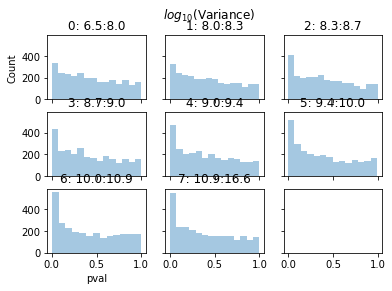

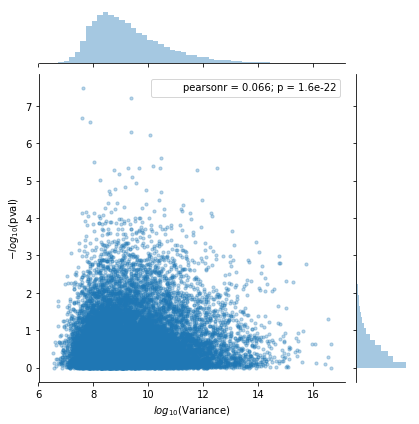

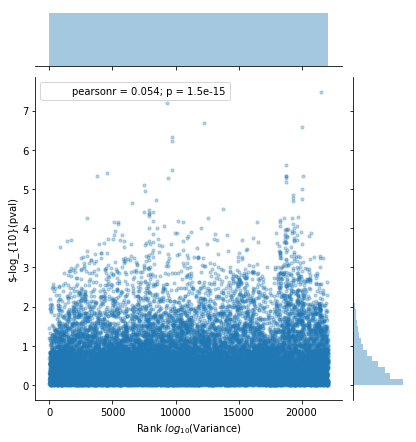

In [265]:
# Variance
pval_strat_hist_and_scatter(np.log10(np.var(zero_filled, axis=0)),
                           mw_pval_series,
                           covar_name='$log_{10}$(Variance)',
                            ngroups=8,
                           title_fxn=None)

Looks like feature-variance is:
* Informative of power/prior probability (height of low pvals increases as variance increases)
* Indepenent of the pvals under null (pvals > 0.5 are roughly uniform)

(See IHW vignette for more, section 3.4.2 - 
https://www.bioconductor.org/packages/release/bioc/vignettes/IHW/inst/doc/introduction_to_ihw.html
)

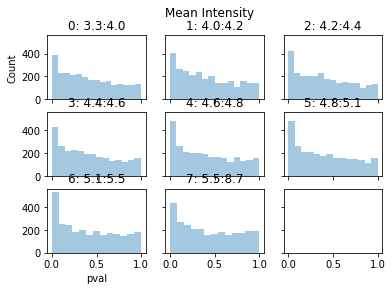

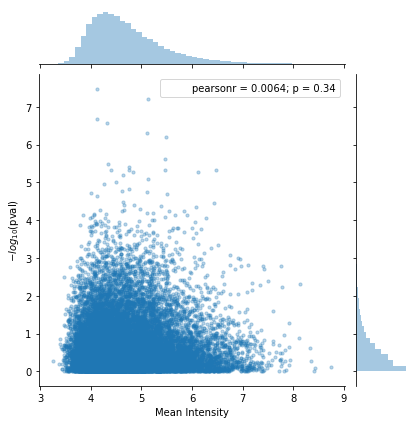

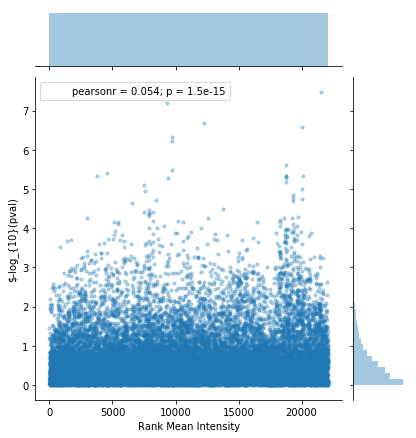

In [266]:
# Mean Intensity
pval_strat_hist_and_scatter(
    np.log10(np.mean(zero_filled, axis=0)),
    mw_pval_series,
    covar_name='Mean Intensity',
    ngroups=8,
    title_fxn=None
    )



Looks like mean feature intensity is:
* NOT informative of power (similar height peak for alt-hypotheses in all strat) 
* IS independent of the p-vals under null hypothesis (uniform-ish for pvals > 0.5)

But this is odd, b/c of how tightly correlated variance and mean intensity are

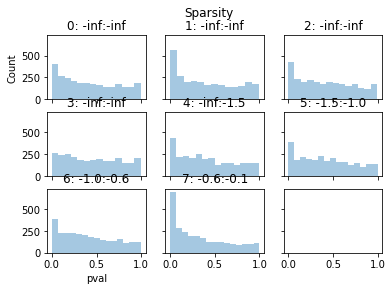

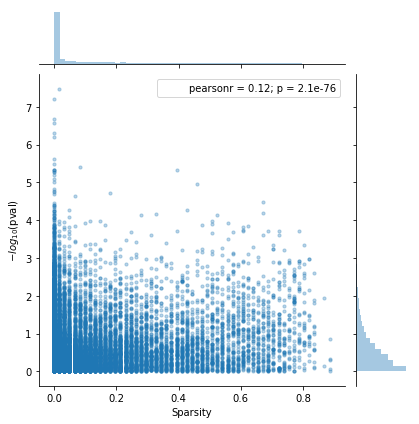

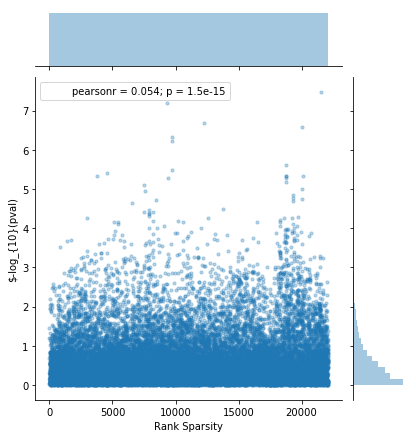

In [269]:
# Feature sparsity
feature_sparsity = ((mtbls315_pos.feature_table < 1e-15).sum(axis=0)
                        / mtbls315_pos.feature_table.shape[0])

pval_strat_hist_and_scatter(
    feature_sparsity,
    mw_pval_series,
    covar_name='Sparsity',
    ngroups=8,
    title_fxn=np.log10
    )

Looks like feature sparsity:
* isn't informative of power (no clear trend between increase/decrease sparsity and inc/dec pval)
* is independent of pvals under null (uniform pvals for p > 0.5)

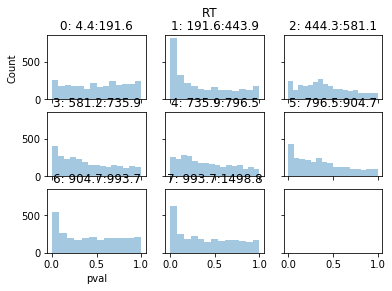

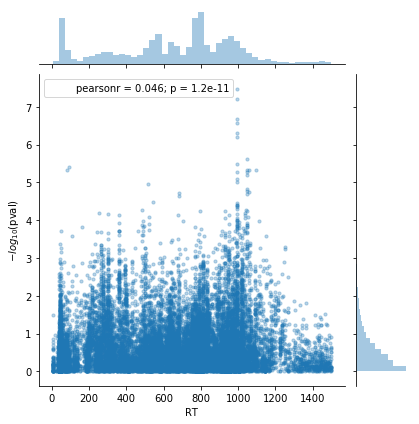

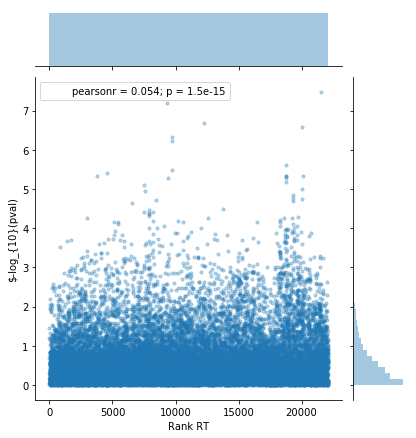

In [272]:
pval_strat_hist_and_scatter(covariates['rt'], mw_pval_series,
                           covar_name='RT', ngroups=8,
                           title_fxn=None)

Looks like RT is
* not informative of power for Mann-whitney
* is independent of pvals under null (uniform-ish for pvals > 0.5)

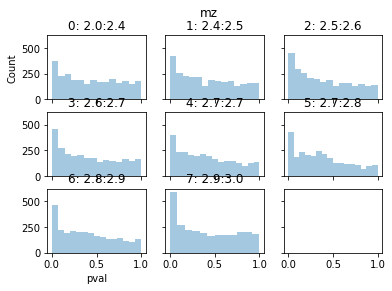

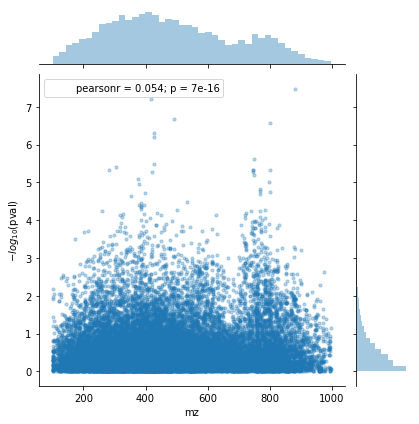

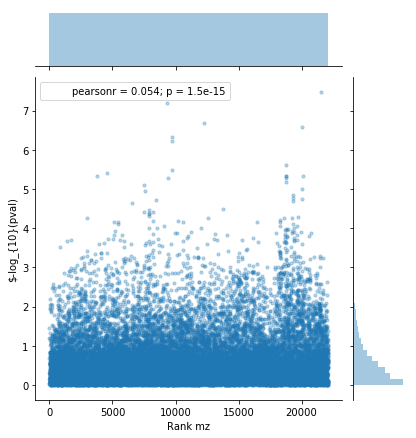

In [273]:
pval_strat_hist_and_scatter(covariates['mz'],
                           mw_pval_series,
                           covar_name='mz',
                           ngroups=8)

Looks like mz:
* Is not indicative of power for mann-whitney 
* is independent under null hypothesis (uniform for p>0.5)

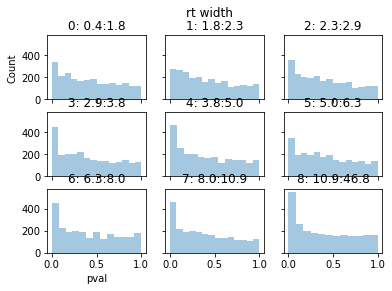

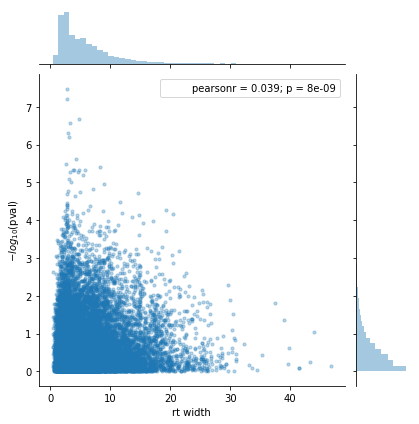

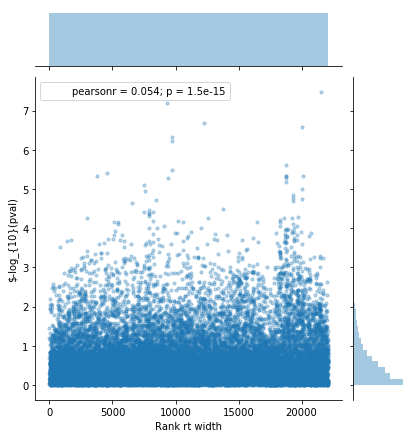

In [276]:
rt_width = covariates['rtmax'] - covariates['rtmin']
pval_strat_hist_and_scatter(rt_width, 
                            mw_pval_series, 
                            covar_name='rt width',
                           ngroups=9,
                           title_fxn=None)

Looks like rt width is 
* not informative of power for mann-whitney
* is independent of null hypothesis

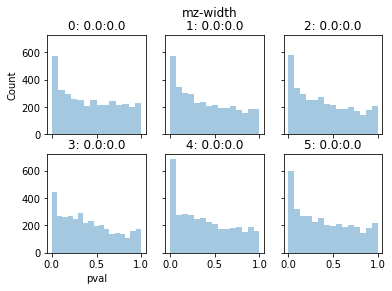

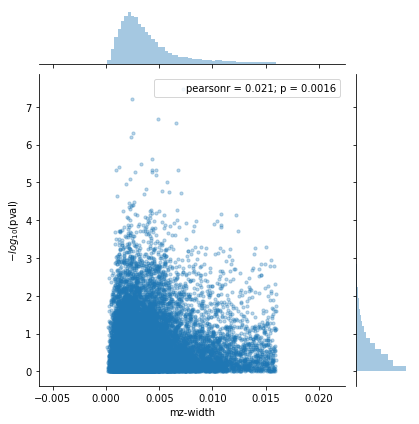

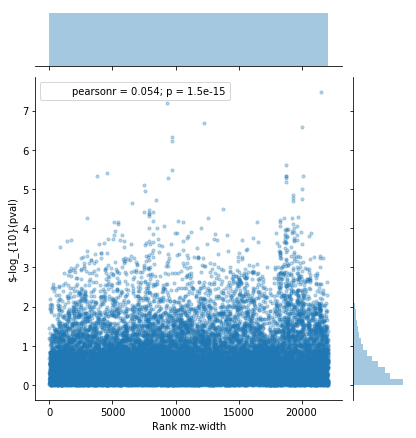

In [282]:
# Check out mz-width
mz_wid = covariates['mzmax'] - covariates['mzmin']
pval_strat_hist_and_scatter(mz_wid, 
                            mw_pval_series,
                            covar_name='mz-width',
                            ngroups=6,
                            title_fxn=None
                           )

Looks like mzwidth is:
* Not informative of power for MW
* is independent under null hypothesis

In [147]:
y == 0

array([ True,  True,  True,  True, False,  True, False,  True, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True], dtype=bool)

In [150]:
# Get class for each sample
new_class_labels = xcms_fxns.encode_new_classes(new_class_dict)
# Make sure orders are right
assert(
    (new_class_labels.index == zero_filled.index).all())
le = preprocessing.LabelEncoder()
y = le.fit_transform(new_class_labels.values)
X = zero_filled.values
pca = PCA(n_components=2, whiten=True)
pca_out = pca.fit_transform(zero_filled)

In [165]:
pca_out[y==0,1].shape

(27,)

In [159]:
le.inverse_transform([0,1])

array(['malaria', 'non-malarial fever'], dtype=object)

In [175]:
le.inverse_transform(np.unique(y))

array(['malaria', 'non-malarial fever'], dtype=object)

('darkorange', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


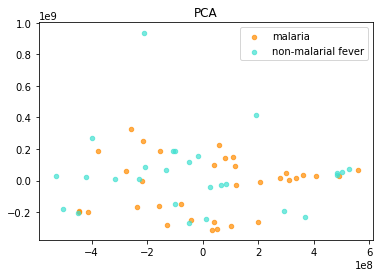

In [386]:
def plot_PCA(data, class_labels):
    # data - samples x feats
    # class_labels - pd.Series, string or numeric, same index as 
    #    data
    # If index doesn't match, reindex and retry
    '''
    
    try: 
        assert((data.index == class_labels.index).all())
    except AssertionError:
        data = data.sort_index()
        class_labels = class_labels.sort_index()
    try:
        assert ((data.index == class_labels.index).all())
    except:
        print('The indices in class_labels and data dont match')
        raise
    '''
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(class_labels.values)
    pca = PCA(n_components=2, whiten=False)
    pca_out = pca.fit_transform(data)
    colors = ['darkorange', 'turquoise']
    encoded_classes = np.unique(y)
    target_names = le.inverse_transform(encoded_classes)
    for color, i, target_name in zip(colors, encoded_classes, target_names):
        print(color, i, target_name)
        plt.scatter(pca_out[y==i,0], pca_out[y==i, 1],
                    color=color, alpha=0.7, label=target_name,
                    s=20
            )
    plt.legend(loc='best', scatterpoints=1)
    plt.title('PCA')
    return pca_out
    
pca_out = plot_PCA(zero_filled, new_class_labels)

In [265]:
X_scaled = preprocessing.scale(zero_filled, axis=0)

('darkorange', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


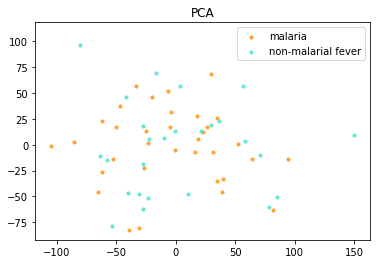

In [266]:
pca_out = plot_PCA(X_scaled, new_class_labels)

In [359]:
# try t-sne
from sklearn import manifold
from sklearn import feature_selection

('Variance Threshold', 0.61774254474818291)


In [404]:
# Do some preprocessing - variance filter and stuff
assert( (new_class_labels.index == zero_filled.index).all())
# toss out 25% lowest variances
X = zero_filled
x_var = np.var(X, axis=0)
sort_idx = x_var.argsort()
num_splits = 8
splits = np.array_split(sort_idx, num_splits)
# This is the variance of the 25% feature
var_thresh = x_var[splits[num_splits-2]].max()
print('Variance Threshold', var_thresh)

# preprocess
selector = feature_selection.VarianceThreshold(var_thresh)
X = selector.fit_transform(X)
print('X shape', X.shape)
X = preprocessing.scale((X))
print('X shape', X.shape)


('Variance Threshold', 74167754603.651352)
('X shape', (61, 2762))
('X shape', (61, 2762))


('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


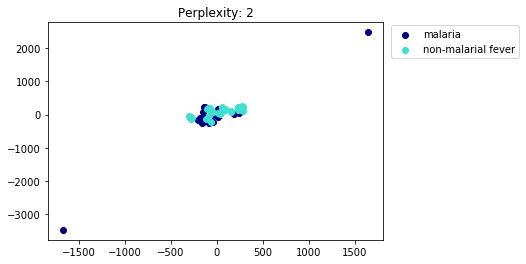

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


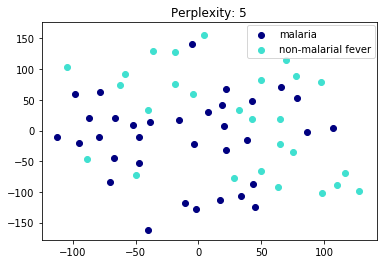

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


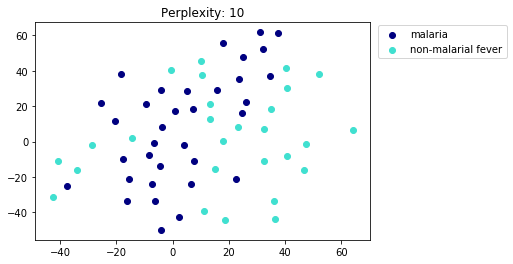

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


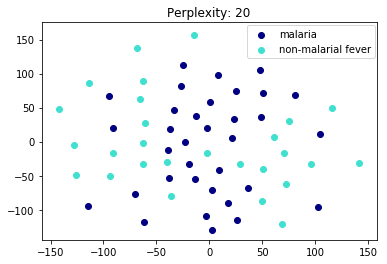

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


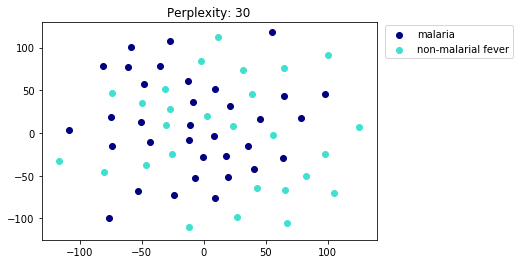

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


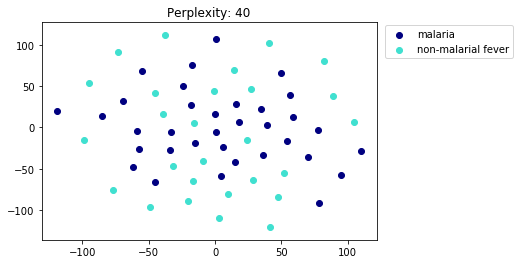

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


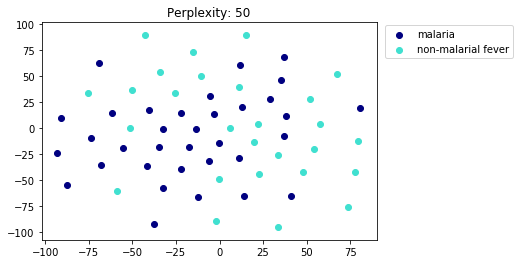

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


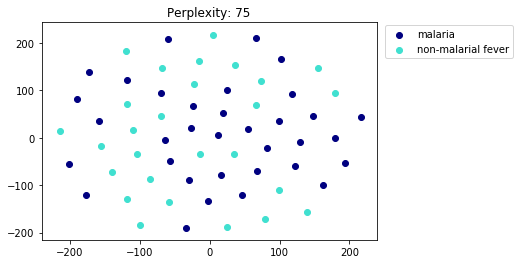

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


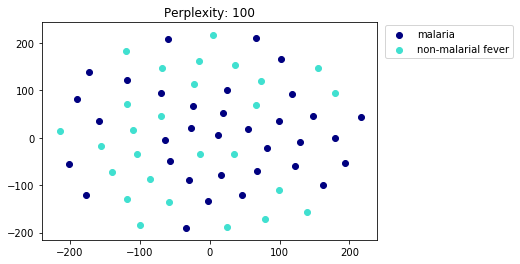

('navy', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


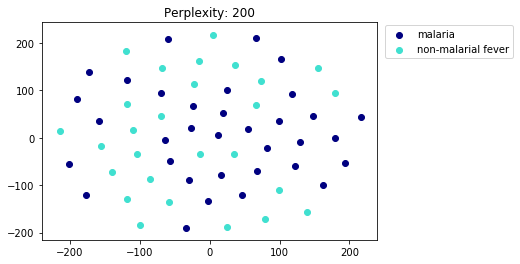

In [406]:
for perplex in [2, 5, 10, 20, 30, 40, 50, 75, 100, 200]:
    tsne = manifold.TSNE(n_components=2, perplexity=perplex,
                  init='random', random_state=1)
    Y = tsne.fit_transform(X)
    colors = ['navy', 'turquoise']
    classes = le.inverse_transform(np.unique(y))
    for color, i, name in zip(colors, np.unique(y), classes):
        print(color, i, name)
        plt.scatter(Y[y==i, 0], Y[y==i, 1], color=color,
                   label=name)
    plt.legend(bbox_to_anchor=(1.01, 1.01))
    plt.title('Perplexity: %s' % perplex)
    plt.show()

('darkorange', 0, 'malaria')
('turquoise', 1, 'non-malarial fever')


(61, 2762)

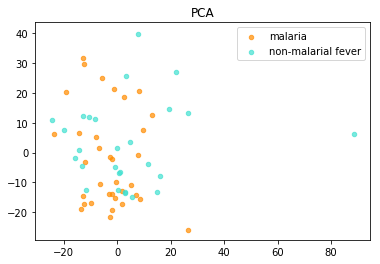

In [407]:
pca_out = plot_PCA(X, new_class_labels)
X.shape

## Now do the preprocessing and some model building
* Also for the artificial sample enrichment, should randomly features from anyone in the class (healthy or sick) - should eliminate the concern that just noising an existing sample will fuck with the cross validation